# Projet Spochify 

In [ ]:
import pandas as pd

# Training
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Log transformation
import numpy as np

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

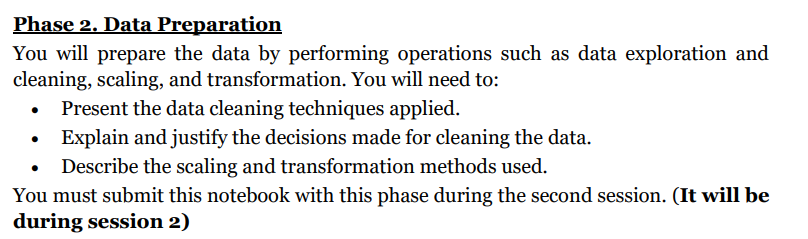

Pre-processing

Traitements fichier .csv

In [43]:
WINE_FILE_PATH = "Data/WineDataset.csv"
wine_df = pd.read_csv(WINE_FILE_PATH, header=0)
wine_df.head()

,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley


In [44]:
len(wine_df)

1290

In [45]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      1290 non-null   object 
 1   Description                1286 non-null   object 
 2   Price                      1290 non-null   object 
 3   Capacity                   1290 non-null   object 
 4   Grape                      1275 non-null   object 
 5   Secondary Grape Varieties  488 non-null    object 
 6   Closure                    1279 non-null   object 
 7   Country                    1284 non-null   object 
 8   Unit                       1281 non-null   float64
 9   Characteristics            1253 non-null   object 
 10  Per bottle / case / each   1290 non-null   object 
 11  Type                       1285 non-null   object 
 12  ABV                        1281 non-null   object 
 13  Region                     1124 non-null   objec

### Data Cleaning

#### 1. Price

Here, we will only focus on price associated to one bottle and remove the other type of prices. Then, we apply a float conversion.

In [46]:
wine_df["Per bottle / case / each"].unique()

array(['per bottle', 'per case', 'each'], dtype=object)

In [47]:
# Remove non per bottle rows
wine_df = wine_df[~wine_df['Price'].str.contains(r'per case|each', case=False, na=False, regex=True)].reset_index(drop=True)

# Convert into float in a new column
wine_df['Price_clean'] = (
    wine_df['Price']
    .str.replace('£', '', regex=False)
    .str.replace(' per bottle', '', regex=False)
    .astype(float)
)

wine_df["Per bottle / case / each"].unique()

wine_df.drop('Per bottle / case / each', axis=1, inplace=True)
wine_df.drop('Price', axis=1, inplace=True)

#### 2. ABV

ABV (Alcool By Volume) needs only a float conversion. 

In [48]:
# Convert into float in a new column
wine_df['ABV_clean'] = wine_df['ABV'].str.extract(r'(\d+\.\d+)').astype(float)

wine_df.drop('ABV', axis=1, inplace=True)

#### 3. Grape

For the grape, we consider only wines with a known grape. Then this values are encoded.

In [49]:
# Number of rows to remove
print(wine_df['Grape'].isna().sum())

# Remove NaN values
wine_df.dropna(subset=['Grape'], inplace=True)

# Encode it
grape_encoded = pd.get_dummies(wine_df['Grape'], prefix='Grape')
wine_df = pd.concat([wine_df, grape_encoded], axis=1)
wine_df.drop('Grape', axis=1, inplace=True)

8


#### 4. Secondary Grape Varieties

As a lot of wines does not especially have a secondary grape variety, we choose to keep NaN rows for this columns, convert into "None" values. Encoding here is quite particular because we handle multiple varietes separated by ','.  

In [50]:
# Number of Nan rows
print(wine_df['Secondary Grape Varieties'].isna().sum())

# Convert NaN values
wine_df['Secondary Grape Varieties'] = wine_df['Secondary Grape Varieties'].fillna('None')

# Convert content into list
wine_df['Secondary Grape Varieties'] = wine_df['Secondary Grape Varieties'].apply(lambda x: [i.strip() for i in x.split(',')] if x != 'None' else [])

# Multilabel encoding
mlb = MultiLabelBinarizer()
secondary_encoded = pd.DataFrame(mlb.fit_transform(wine_df['Secondary Grape Varieties']),
                                 columns=[f'Secondary_{c}' for c in mlb.classes_])

wine_df = pd.concat([wine_df, secondary_encoded], axis=1)
wine_df.drop('Secondary Grape Varieties', axis=1, inplace=True)

# All encoded columns for grapes
print(wine_df.columns.tolist())
print(wine_df.shape)

785
['Title', 'Description', 'Capacity', 'Closure', 'Country', 'Unit', 'Characteristics', 'Type', 'Region', 'Style', 'Vintage', 'Appellation', 'Price_clean', 'ABV_clean', 'Grape_Agiorgitiko', 'Grape_Aglianico', 'Grape_Airen', 'Grape_Albarino', 'Grape_Alicante Bouschet', 'Grape_Aligoté', 'Grape_Alvarinho', 'Grape_Arinto', 'Grape_Assyrtiko', 'Grape_Bacchus', 'Grape_Barbera', 'Grape_Black Muscat', 'Grape_Cabernet Franc', 'Grape_Cabernet Sauvignon', 'Grape_Carignan', 'Grape_Carménère', 'Grape_Castelão ', 'Grape_Chardonnay', 'Grape_Chenin Blanc', 'Grape_Cinsault', 'Grape_Colombard', 'Grape_Cortese', 'Grape_Corvina', 'Grape_Dolcetto', 'Grape_Falanghina', 'Grape_Fernão Pires', 'Grape_Feteasca Alba', 'Grape_Fiano', 'Grape_Furmint', 'Grape_Gamay', 'Grape_Garganega', 'Grape_Garnacha', 'Grape_Gewürztraminer', 'Grape_Glera', 'Grape_Godello', 'Grape_Greco', 'Grape_Grenache', 'Grape_Grenache Blanc', 'Grape_Grillo', 'Grape_Grolleau', 'Grape_Gruner Veltliner', 'Grape_Huxelrebe', 'Grape_Inzolia', 'Grap

#### 5. Region, Style, Country, Type, Appellation and Characteristics

In [51]:
# -----------------------------
# 1. One-Hot Encoding
# -----------------------------
columns_to_encode = ['Region', 'Style', 'Country', 'Type', 'Appellation']

for col in columns_to_encode:
    wine_df[col] = wine_df[col].fillna('None')
    dummies = pd.get_dummies(wine_df[col], prefix=col)
    wine_df = pd.concat([wine_df, dummies], axis=1)
    wine_df.drop(col, axis=1, inplace=True)

# --------------------------------------
# 2. Multi-label Binarizer for 'Characteristics'
# --------------------------------------

# Convert into list
wine_df['Characteristics'] = wine_df['Characteristics'].fillna('None')
wine_df['Characteristics'] = wine_df['Characteristics'].apply(
    lambda x: [] if x == 'None' else [i.strip() for i in x.split(',')]
)

# MultiLabelBinarizer
mlb = MultiLabelBinarizer()
char_encoded = pd.DataFrame(
    mlb.fit_transform(wine_df['Characteristics']),
    columns=[f'Char_{c}' for c in mlb.classes_]
)

wine_df = pd.concat([wine_df, char_encoded], axis=1)
wine_df.drop('Characteristics', axis=1, inplace=True)

# All encoded columns for grapes
print(wine_df.columns.tolist())
print(wine_df.shape)

['Title', 'Description', 'Capacity', 'Closure', 'Unit', 'Vintage', 'Price_clean', 'ABV_clean', 'Grape_Agiorgitiko', 'Grape_Aglianico', 'Grape_Airen', 'Grape_Albarino', 'Grape_Alicante Bouschet', 'Grape_Aligoté', 'Grape_Alvarinho', 'Grape_Arinto', 'Grape_Assyrtiko', 'Grape_Bacchus', 'Grape_Barbera', 'Grape_Black Muscat', 'Grape_Cabernet Franc', 'Grape_Cabernet Sauvignon', 'Grape_Carignan', 'Grape_Carménère', 'Grape_Castelão ', 'Grape_Chardonnay', 'Grape_Chenin Blanc', 'Grape_Cinsault', 'Grape_Colombard', 'Grape_Cortese', 'Grape_Corvina', 'Grape_Dolcetto', 'Grape_Falanghina', 'Grape_Fernão Pires', 'Grape_Feteasca Alba', 'Grape_Fiano', 'Grape_Furmint', 'Grape_Gamay', 'Grape_Garganega', 'Grape_Garnacha', 'Grape_Gewürztraminer', 'Grape_Glera', 'Grape_Godello', 'Grape_Greco', 'Grape_Grenache', 'Grape_Grenache Blanc', 'Grape_Grillo', 'Grape_Grolleau', 'Grape_Gruner Veltliner', 'Grape_Huxelrebe', 'Grape_Inzolia', 'Grape_Jacquere', 'Grape_Lambrusco Grasparossa', 'Grape_Loureiro', 'Grape_Macabeo

#### 6. Drop NaN and useless columns

In [52]:
print(wine_df.isna().any(axis=1).sum())
wine_df.dropna(inplace=True)

21


In [53]:
wine_df.drop(columns=["Description", "Unit", "Capacity", "Closure", "Vintage"], inplace=True)
wine_df.head()

,Title,Price_clean,ABV_clean,Grape_Agiorgitiko,Grape_Aglianico,Grape_Airen,Grape_Albarino,Grape_Alicante Bouschet,Grape_Aligoté,Grape_Alvarinho,...,Char_Tobacco,Char_Toffee,Char_Tomato Leaf,Char_Tropical Fruit,Char_Vanilla,Char_Violet,Char_Walnut,Char_Watermelon,Char_Wet Stones,Char_White Pepper
0,"The Guv'nor, Spain",9.99,14.0,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Bread & Butter 'Winemaker's Selection' Chardon...,15.99,13.5,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",12.49,13.0,False,False,False,False,False,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Louis Latour Mâcon-Lugny 2021/22,17.99,13.5,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bread & Butter 'Winemaker's Selection' Pinot N...,15.99,13.5,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data training

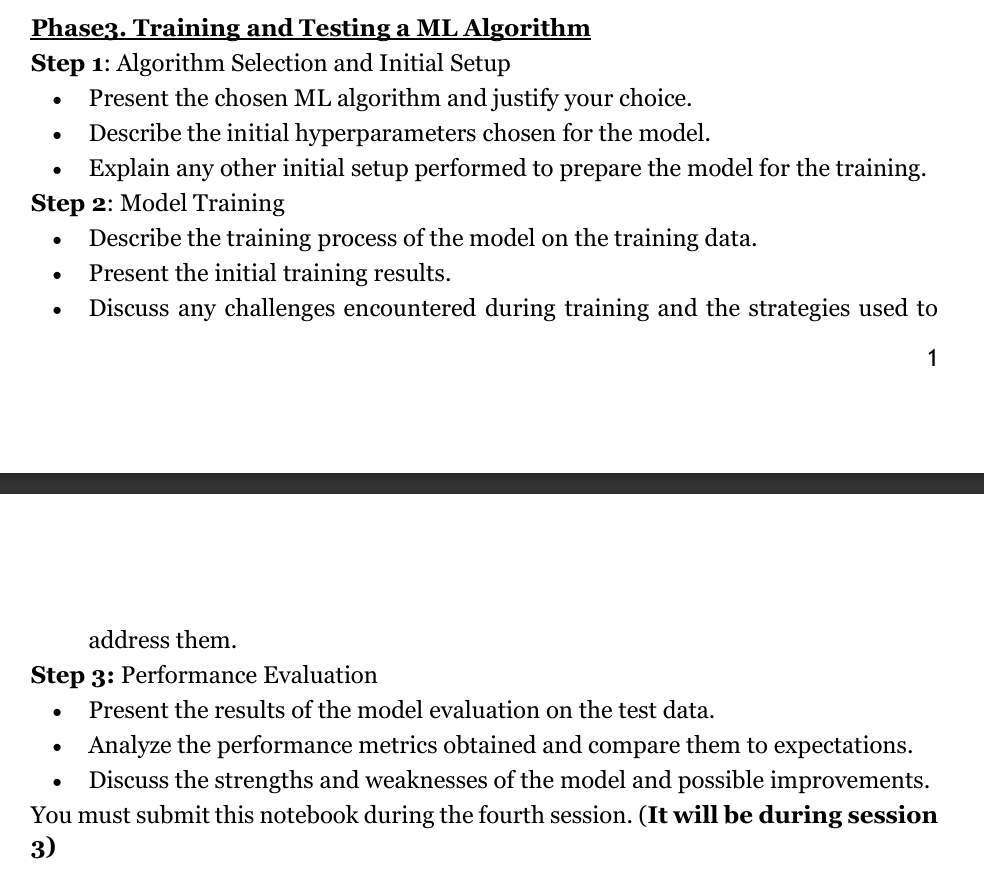

#### 1. Model training for price detection with Ridge

Regression for price detection with Ridge.

Gère très bien la régularisation avec beaucoup de colonnes. (Source : GPT)

MSE : 1410.20
MAE : 25.99
R² Score : -0.20
    Réel     Prédit
0   9.99  33.078164
1  14.99 -19.381090
2  12.99  11.069084
3  18.99  33.754915
4  64.99  71.776249
5   8.99   4.298478
6  13.99  53.134677
7  17.99  53.331771
8  24.99  32.930679
9  36.99   7.440210


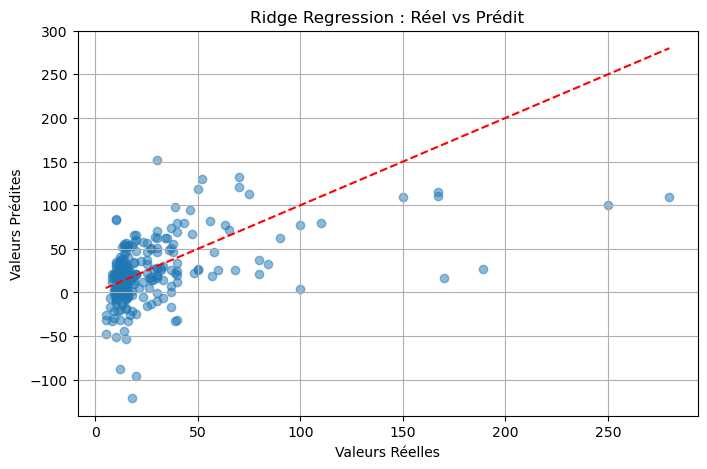

In [54]:
# 1. Séparation des données
titles = wine_df['Title']
X = wine_df.drop(columns=['Price_clean', 'Title'])  # ou autre cible
y = wine_df['Price_clean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Pipeline StandardScaler + Ridge
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])


# 3. Entraînement
model_pipeline.fit(X_train, y_train)

# 4. Prédictions
y_pred = model_pipeline.predict(X_test)

# 5. Évaluation
print(f"MSE : {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score : {r2_score(y_test, y_pred):.2f}")

# 6. Comparaison valeurs réelles vs prédites
results = pd.DataFrame({
    'Réel': y_test.values,
    'Prédit': y_pred
}).reset_index(drop=True)

print(results.head(10))  # Voir les 10 premières comparaisons

# 7. Graphique
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonale parfaite
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.title('Ridge Regression : Réel vs Prédit')
plt.grid(True)
plt.show()


#### 2. Model training with Linear Regression

Transformation log utilisée pour éviter les valeurs négatives.

MSE : 3100.33
MAE : 31.02
R² Score : -1.63
    Réel      Prédit
0   9.99  148.413159
1  14.99   16.424049
2  12.99   13.522695
3  18.99   17.019807
4  64.99   58.729344
5   8.99   10.805226
6  13.99   18.943668
7  17.99   30.243227
8  24.99    0.006738
9  36.99  148.413159


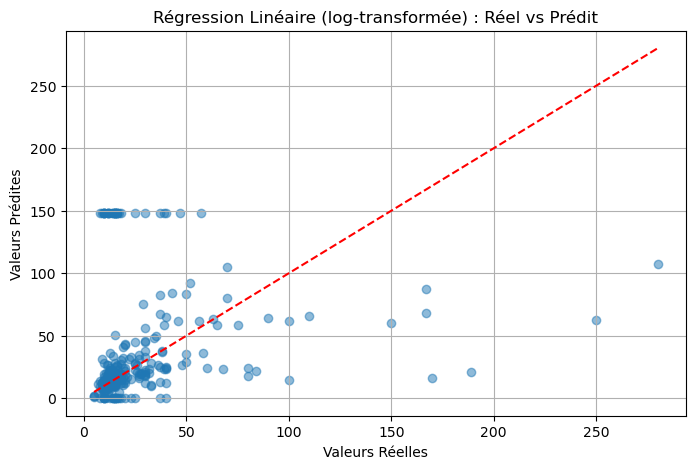

In [55]:
# 1. Séparation des données
titles = wine_df['Title']
X = wine_df.drop(columns=['Price_clean', 'Title'])  # ou autre cible
y = wine_df['Price_clean']

# Transformation log (log des prix)
y_log = np.log(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 2. Pipeline StandardScaler + LinearRegression
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])

# 3. Entraînement
model_pipeline.fit(X_train, y_train_log)

# 4. Prédictions (log space)
y_pred_log = model_pipeline.predict(X_test)


# 5. Transformation inverse : exp(log(y)) = y
y_pred_log_clipped = np.clip(y_pred_log, a_min=-5, a_max=5)  # tighter range than before
y_pred = np.exp(y_pred_log_clipped)
y_test = np.exp(y_test_log)  # on remet aussi y_test à l'échelle originale

# 6. Évaluation
print(f"MSE : {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score : {r2_score(y_test, y_pred):.2f}")

# 7. Comparaison valeurs réelles vs prédites
results = pd.DataFrame({
    'Réel': y_test.values,
    'Prédit': y_pred
}).reset_index(drop=True)

print(results.head(10))

# 8. Graphique
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonale parfaite
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.title('Régression Linéaire (log-transformée) : Réel vs Prédit')
plt.grid(True)
plt.show()


### 3. Training with Lasso


MSE : 841.09
MAE : 12.09
R² Score : 0.29
    Réel     Prédit
0   9.99  12.945814
1  14.99  15.489233
2  12.99  16.047129
3  18.99  15.297537
4  64.99  57.733912
5   8.99   8.603065
6  13.99  12.726353
7  17.99  24.107603
8  24.99  19.001050
9  36.99  20.217719


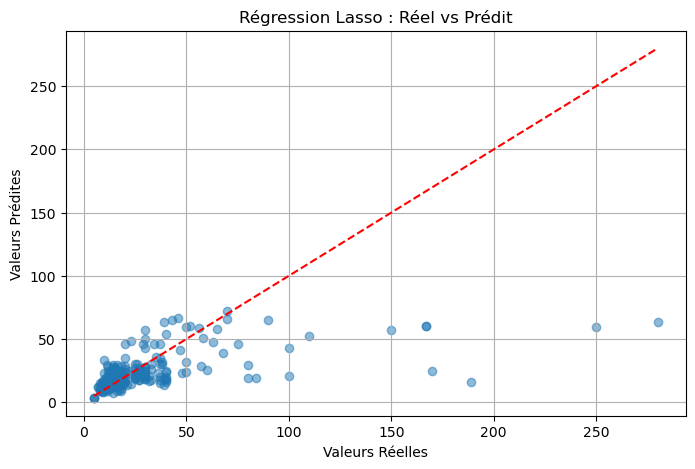

In [ ]:
# 1. Séparation des données
titles = wine_df['Title']
X = wine_df.drop(columns=['Price_clean', 'Title'])  # ou autre cible
y = wine_df['Price_clean']

# Transformation log (log des prix)
y_log = np.log(y)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 2. Pipeline StandardScaler + LinearRegression
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.01, random_state=1000))
])

# 3. Entraînement
model_pipeline.fit(X_train, y_train_log)

# 4. Prédictions (log space)
y_pred_log = model_pipeline.predict(X_test)
# Clip predictions to avoid overflow in exp
y_pred_log_clipped = np.clip(y_pred_log, a_min=0, a_max=5)

# 5. transformation inverse
y_pred = np.exp(y_pred_log_clipped)
y_test = np.exp(y_test_log)  

# 6. Évaluation
print(f"MSE : {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score : {r2_score(y_test, y_pred):.2f}")

# 7. Comparaison valeurs réelles vs prédites
results = pd.DataFrame({
    'Réel': y_test.values,
    'Prédit': y_pred
}).reset_index(drop=True)

print(results.head(10))

# 8. Graphique
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonale parfaite
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Régression Lasso : Actual vs Predicted values')
plt.grid(True)
plt.show()




### 4. Comparing with an ensemble method (Stacking)

In [ ]:
# 1. Séparation des données
titles = wine_df['Title']
X = wine_df.drop(columns=['Price_clean', 'Title'])  # ou autre cible
y = wine_df['Price_clean']

# Transformation log (log des prix)
y_log = np.log(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)


# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=500, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=500, random_state=42)),
    ('lr', LinearRegression())
]

# Define stacking regressor with LinearRegression as meta-model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5  # cross-validation folds for training meta-model
)

# Train stacking model
stacking_model.fit(X_train, y_train)

# Predict
y_pred = stacking_model.predict(X_test)

# Evaluate

# 7. Comparaison valeurs réelles vs prédites
results = pd.DataFrame({
    'Réel': y_test.values,
    'Prédit': y_pred
}).reset_index(drop=True)

print(results.head(20))

print(f"MSE : {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score : {r2_score(y_test, y_pred):.2f}")

      Réel     Prédit
0     9.99  18.697682
1    14.99  16.747535
2    12.99  21.608020
3    18.99  24.899450
4    64.99  53.664610
5     8.99  14.894901
6    13.99  17.858042
7    17.99  22.722050
8    24.99  21.516767
9    36.99  22.819716
10   79.99  38.701429
11   89.99  57.729689
12   14.99  19.130388
13   12.99  20.086567
14   24.99  20.868198
15   34.99  33.715090
16   29.99  20.511126
17   27.99  24.154847
18   11.99  19.671768
19  166.99  76.041974
MSE : 783.55
MAE : 13.74
R² Score : 0.34


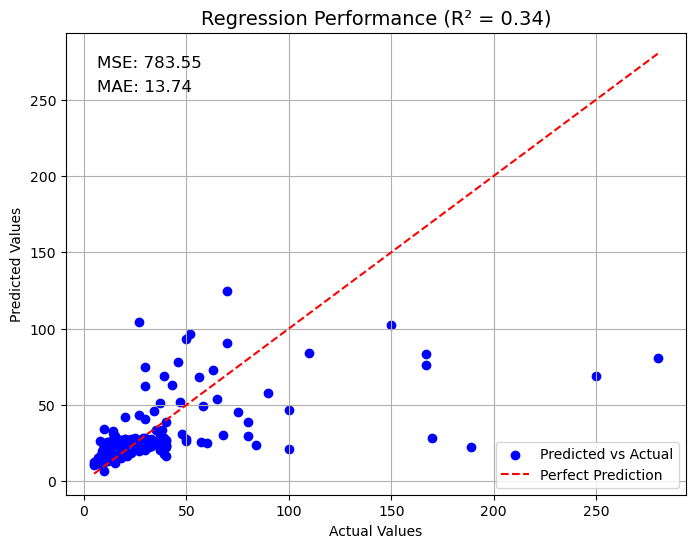

In [70]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')

# Annotate MSE and MAE
plt.text(0.05, 0.95, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Title with R² score
plt.title(f'Regression Performance (R² = {r2:.2f})', fontsize=14)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()